In [2]:
import pandas as pd
import zipfile
import pymongo
from pymongo import MongoClient
import chardet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
from flask import Flask, jsonify

In [5]:
#Importing data
#Questions to answer:
#Who is the goat? Who has the highest average similarity score for all jobs?
#Who is best fit for a job?

jobs_import=pd.read_csv('data job posts.csv',encoding = "utf-8")
resume_import=pd.read_csv('UpdatedResumeDataSet - Copy.csv',engine="python", encoding="utf-8")
# #Why won't you give me the correct formatting????
# path = 'UpdatedResumeDataSet - Copy.csv'
# with open(path, mode='rb') as f:
#     binary = f.read()
#     code = chardet.detect(binary)['encoding']
#     print(code)

In [75]:
resume_category_list=list(resume_import.iloc[:5,0])
resume_category_list

['Data Science',
 'Data Science',
 'Data Science',
 'Data Science',
 'Data Science']

In [72]:
company_list=list(jobs_import.iloc[:5,3])
company_list

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

In [6]:
#Remove all non utf-8 characters
resume_import_clean=resume_import.replace('[^a-zA-Z\d\_.]+',' ',regex=True)
jobs_import_clean=jobs_import.replace('[^a-zA-Z\d\_.]+',' ',regex=True)

In [ ]:
# use cosign similary to see how similar all job postings are to other job postings
post=jobs_import_clean['jobpost']
cv = CountVectorizer()
count_matrix = cv.fit_transform(post)
cosine_sim = cosine_similarity(count_matrix)

In [7]:
post=jobs_import_clean['jobpost']
cv = CountVectorizer()
count_matrix = cv.fit_transform(post)
cosine_sim = cosine_similarity(count_matrix)



In [8]:
# use cosign similary to see how similar all resumes are to other resumes
resume_desc=resume_import_clean['Resume']
count_matrix_resume = cv.fit_transform(resume_desc)
cosine_sim_resume = cosine_similarity(count_matrix_resume)


In [9]:
#stack job posts in same column as resume in data frame so that cosign similarity of everything can be determined
job_resume_stack=pd.concat([resume_desc,post],ignore_index=True)
job_resume_stackdf=pd.DataFrame(job_resume_stack)


In [10]:
#Calculate cosign similarity of everything
job_resume_stack_info=job_resume_stackdf.iloc[:,0]
count_matrix_stack = cv.fit_transform(job_resume_stack_info)
cosine_sim_stack = cosine_similarity(count_matrix_stack)

In [11]:
# make sure the stack is a data frame
cosine_sim_stackdf=pd.DataFrame(cosine_sim_stack)
#Create stack dataframe to hold stats
stack=pd.DataFrame()
# Add mean cosign similarity of every row into a column named "mean"
cosine_sim_stackdf['mean']=cosine_sim_stackdf.mean(axis=1)
#Comaring resumes to jobs
stack['resume_mean']=cosine_sim_stackdf.iloc[19002:,:19002].mean(axis=1)
#comparing all jobs to jobs
#Not sure why job_mean doesn't plot here. Can be corrected by taking out on of the historgrams.
stack['job_mean']=cosine_sim_stackdf.iloc[0:19001,0:19001].mean(axis=1)
stack.hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F6E26EA390>,
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F6E39B3908>,
      dtype=object)

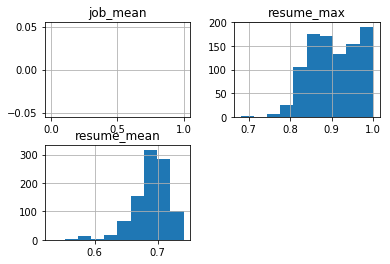

In [12]:
stack['resume_max']=cosine_sim_stackdf.iloc[19002:,:19002].max(axis=1)
stack.hist()

In [13]:
#Who is the best fit for specific job?
like_a_glove=stack[stack['resume_max']>.999]
like_a_glove

,resume_mean,job_mean,resume_max
19040,0.712837,NaN,0.999586
19045,0.716368,NaN,0.999449
19266,0.684906,NaN,0.999263
19641,0.717245,NaN,0.999021


In [14]:
#highers average similary score doesn't have the highest max similarity.  May need to look by job description
cosine_simdf=pd.DataFrame(cosine_sim)
goat=stack[stack['resume_mean']>.74]
goat

,resume_mean,job_mean,resume_max
19308,0.741292,NaN,0.915805
19875,0.740877,NaN,0.955529


In [15]:
#This mf'r has a background in cosign similarity projects and also has the highest resume to job similarity!!!!
resume_desc.iloc[38]

'Personal Skills Ability to quickly grasp technical aspects and willingness to learn High energy levels Result oriented. Education Details January 2018 Master of Engineering Computer Technology Application Bhopal Madhya Pradesh Truba Institute of Engineering Information Technology January 2010 B.E. computer science Bhopal Madhya Pradesh RKDF Institute of Science and Technology College of Engineering January 2006 Polytechnic Information Technology Vidisha Madhya Pradesh SATI Engineering College in Vidisha January 2003 M.tech Thesis Detail BMCH School in Ganj basoda Data science I have six month experience in Data Science. Key Skills Experience in Machine Learning Deep Leaning NLP Python SQL Web Scraping Good knowledge in computer subjects and ability to update Skill Details Experience in Machine Learning Deep Learning NLP Python SQL Web Crawling HTML CSS. Exprience Less than 1 year monthsCompany Details company RNT.AI Technology Solution description Text classification using Machine lea

In [16]:
A=jobs_import_clean.to_dict('records')
B=resume_import_clean.to_dict('records')
B[0]

{'Category': 'Data Science',
 'Resume': 'Skills Programming Languages Python pandas numpy scipy scikit learn matplotlib Sql Java JavaScript JQuery. Machine learning Regression SVM Na ve Bayes KNN Random Forest Decision Trees Boosting techniques Cluster Analysis Word Embedding Sentiment Analysis Natural Language processing Dimensionality reduction Topic Modelling LDA NMF PCA Neural Nets. Database Visualizations Mysql SqlServer Cassandra Hbase ElasticSearch D3.js DC.js Plotly kibana matplotlib ggplot Tableau. Others Regular Expression HTML CSS Angular 6 Logstash Kafka Python Flask Git Docker computer vision Open CV and understanding of Deep learning.Education Details Data Science Assurance Associate Data Science Assurance Associate Ernst Young LLP Skill Details JAVASCRIPT Exprience 24 months jQuery Exprience 24 months Python Exprience 24 monthsCompany Details company Ernst Young LLP description Fraud Investigations and Dispute Services Assurance TECHNOLOGY ASSISTED REVIEW TAR Technology 

In [17]:
#Combine data into mongodb
conn = "mongodb://localhost:27017"
client = pymongo.MongoClient(conn)

In [18]:
#set up tables in db
db = client.job_resume
resume = db.resume
job=db.job

In [19]:
#insert data to tables
job.insert_many(A)
resume.insert_many(B)

In [22]:
resume[0].text

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'job_resume'), 'resume.0.text')

In [28]:
job_request=job.find()
job_request_list=list(job_request)
five_job=job_request_list[:5]

[{'_id': ObjectId('6161c1dd1d412c3b26e532b3'),
  'jobpost': 'AMERIA Investment Consulting Company JOB TITLE Chief Financial Officer POSITION LOCATION Yerevan Armenia JOB DESCRIPTION AMERIA Investment Consulting Company is seeking a Chief Financial Officer. This position manages the company s fiscal and administrative functions provides highly responsible and technically complex staff assistance to the Executive Director. The work performed requires a high level of technical proficiency in financial management and investment management as well as management supervisory and administrative skills. JOB RESPONSIBILITIES Supervises financial management and administrative staff including assigning responsibilities reviewing employees work processes and products counseling employees giving performance evaluations and recommending disciplinary action Serves as member of management team participating in both strategic and operational planning for the company Directs and oversees the company s fi

In [ ]:
# job_limited=db.five_job
# job_limited.insert_many

In [30]:
resume_request=resume.find()
resume_request_list=list(resume_request)
five_resume=resume_request_list[:5]
five_resume

[{'_id': ObjectId('6161d1fe1d412c3b26e5c727'),
  'Category': 'Data Science',
  'Resume': 'Skills Programming Languages Python pandas numpy scipy scikit learn matplotlib Sql Java JavaScript JQuery. Machine learning Regression SVM Na ve Bayes KNN Random Forest Decision Trees Boosting techniques Cluster Analysis Word Embedding Sentiment Analysis Natural Language processing Dimensionality reduction Topic Modelling LDA NMF PCA Neural Nets. Database Visualizations Mysql SqlServer Cassandra Hbase ElasticSearch D3.js DC.js Plotly kibana matplotlib ggplot Tableau. Others Regular Expression HTML CSS Angular 6 Logstash Kafka Python Flask Git Docker computer vision Open CV and understanding of Deep learning.Education Details Data Science Assurance Associate Data Science Assurance Associate Ernst Young LLP Skill Details JAVASCRIPT Exprience 24 months jQuery Exprience 24 months Python Exprience 24 monthsCompany Details company Ernst Young LLP description Fraud Investigations and Dispute Services Ass

In [31]:
five_post=post.iloc[:5]
five_resume_desc=resume_desc.iloc[:5]
short_stack=pd.concat([five_post,five_resume_desc],ignore_index=True)
short_stack

0    AMERIA Investment Consulting Company JOB TITLE...
1    International Research Exchanges Board IREX TI...
2    Caucasus Environmental NGO Network CENN JOB TI...
3    Manoff Group JOB TITLE BCC Specialist POSITION...
4    Yerevan Brandy Company JOB TITLE Software Deve...
5    Skills Programming Languages Python pandas num...
6    Education Details May 2013 to May 2017 B.E UIT...
7    Areas of Interest Deep Learning Control System...
8    Skills R Python SAP HANA Tableau SAP HANA SQL ...
9    Education Details MCA YMCAUST Faridabad Haryan...
dtype: object

In [87]:
five_postdf=pd.DataFrame(five_post)
five_resume_descdf=pd.DataFrame(five_resume_desc)
count_matrix_five_postdf = cv.fit_transform(five_postdf)
count_matrix_five_resume_descdf = cv.fit_transform(five_resume_descdf)
cosine_sim_short_stack=pd.concat([five_post,five_resume_desc],ignore_index=True)
cosine_sim_short_stackdf=pd.DataFrame(cosine_sim_short_stack)
#fit_transform the short list data
cosine_sim_short_stackdf_fit=cv.fit_transform(short_stack)

cosine_sim_short_stack_score=cosine_similarity(cosine_sim_short_stackdf_fit)
cosine_sim_short_stack_score_df=pd.DataFrame(cosine_sim_short_stack_score)
cosine_sim_short_stack_score_df
short_cos=cosine_sim_short_stack_score_df.iloc[5:,:5]
short_cos
# cosine_sim_short_stack = cosine_similarity(count_matrix_five_postdf,count_matrix_five_resume_descdf)
# cosine_sim_short_stackdf=pd.DataFrame(cosine_sim_short_stack)
# cosine_sim_short_stackdf.hist()

,0,1,2,3,4
5,0.604489,0.541603,0.529546,0.574443,0.382704
6,0.316574,0.265925,0.254875,0.280936,0.149504
7,0.329503,0.383072,0.327441,0.351268,0.310978
8,0.520224,0.497880,0.457364,0.537914,0.387329
9,0.023621,0.017370,0.006417,0.003096,0.018160


In [88]:
post

0        AMERIA Investment Consulting Company JOB TITLE...
1        International Research Exchanges Board IREX TI...
2        Caucasus Environmental NGO Network CENN JOB TI...
3        Manoff Group JOB TITLE BCC Specialist POSITION...
4        Yerevan Brandy Company JOB TITLE Software Deve...
                               ...                        
18996    Technolinguistics NGO TITLE Senior Creative UX...
18997     Coca Cola Hellenic Bottling Company Armenia C...
18998     Coca Cola Hellenic Bottling Company Armenia C...
18999    San Lazzaro LLC TITLE Head of Online Sales Dep...
19000     Kamurj UCO CJSC TITLE Lawyer in Legal Departm...
Name: jobpost, Length: 19001, dtype: object

In [103]:
my_list = short_cos.columns.values.tolist()


AttributeError: 'list' object has no attribute 'to_string'

In [106]:
short_cos.columns=short_cos.columns.astype(str)
short_cos.columns

Index(['0', '1', '2', '3', '4'], dtype='object')

In [107]:
#Create database
job_limited=db.five_job
#Convert data for database



C=short_cos.to_dict('Records')

job_limited.insert_many(C)
job_limited.find()

In [97]:
C

[{0: 0.6044888229172193,
  1: 0.5416033706753954,
  2: 0.5295455582508979,
  3: 0.5744426726585407,
  4: 0.3827044825148655},
 {0: 0.31657381929463596,
  1: 0.2659250754082747,
  2: 0.25487527328490694,
  3: 0.28093639569499135,
  4: 0.14950385751617898},
 {0: 0.3295032196309082,
  1: 0.38307180709576705,
  2: 0.32744141353453354,
  3: 0.3512677878411081,
  4: 0.3109777502094318},
 {0: 0.5202237606345046,
  1: 0.4978798906578481,
  2: 0.4573640731987174,
  3: 0.5379141984506879,
  4: 0.3873286699928712},
 {0: 0.023620522009382312,
  1: 0.01736954202570263,
  2: 0.006416969167544688,
  3: 0.003095657098046908,
  4: 0.01815985952865452}]